##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 훈련 후 정수 양자화

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/lite/performance/post_training_integer_quant"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/lite/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/lite/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/lite/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

## 개요

정수 양자화는 32bit 부동 소수점 숫자(예: 가중치 및 활성화 출력)를 가장 가까운 8bit 고정 소수점 숫자로 변환하는 최적화 전략입니다. 그 결과 모델이 작아지고 추론 속도가 증가하여 [마이크로 컨트롤러](https://www.tensorflow.org/lite/microcontrollers)와 같은 저전력 장치에 유용합니다. 이 데이터 형식은 [에지 TPU](https://coral.ai/)와 같은 정수 전용 가속기에도 필요합니다.

이 가이드에서는 MNIST 모델을 처음부터 훈련하고 Tensorflow Lite 파일로 변환하고 [훈련 후 양자화](https://www.tensorflow.org/lite/performance/post_training_quantization)로 양자화합니다. 마지막으로 변환된 모델의 정확성을 확인하고 원본 부동 모델과 비교합니다.

실제로 모델을 양자화하려는 정도에 대한 몇 가지 옵션이 있습니다. 이 튜토리얼에서는 모든 가중치와 활성화 출력을 8bit 정수 데이터로 변환하는 '전체 정수 양자화'를 수행합니다. 반면 다른 전략은 일부 양의 데이터를 부동 소수점에 남길 수 있습니다.

다양한 양자화 전략에 대해 자세히 알아 보려면 [TensorFlow Lite 모델 최적화](https://www.tensorflow.org/lite/performance/model_optimization)에 대해 읽어보세요.


## 설정

입력 및 출력 텐서를 양자화하려면 TensorFlow r2.3에 추가된 API를 사용해야 합니다.

In [ ]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
import numpy as np
assert float(tf.__version__[:3]) >= 2.3

## TensorFlow 모델 생성하기

[MNIST 데이터세트](https://www.tensorflow.org/datasets/catalog/mnist)에서 숫자를 분류하는 간단한 모델을 만들어 보겠습니다.

이 훈련은 약 ~98%의 정확성으로 훈련하는 단 5 epoch 동안 모델을 훈련하기 때문에 오래 걸리지 않을 것입니다.

In [ ]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_data=(test_images, test_labels)
)

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2793 - accuracy: 0.9227 - val_loss: 0.1392 - val_accuracy: 0.9618
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1179 - accuracy: 0.9667 - val_loss: 0.0928 - val_accuracy: 0.9719
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0860 - accuracy: 0.9754 - val_loss: 0.0742 - val_accuracy: 0.9755
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0691 - accuracy: 0.9796 - val_loss: 0.0686 - val_accuracy: 0.9776
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0589 - accuracy: 0.9823 - val_loss: 0.0654 - val_accuracy: 0.9787


## TensorFlow Lite 모델로 변환하기

이제 [`TFLiteConverter` ](https://www.tensorflow.org/lite/convert/python_api) API를 사용하여 훈련된 모델을 TensorFlow Lite 형식으로 변환하고 다양한 정도의 양자화를 적용할 수 있습니다.

일부 양자화 버전은 일부 데이터를 부동 형식으로 남겨 둡니다. 따라서 다음 섹션에서는 완전히 int8 또는 uint8 데이터인 모델을 얻을 때까지 양자화 양이 증가하는 각 옵션을 보여줍니다(각 옵션에 대한 모든 양자화 단계를 볼 수 있도록 각 섹션에서 일부 코드를 복제합니다).

먼저, 양자화없이 변환된 모델이 있습니다.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

이제 TensorFlow Lite 모델이지만 모든 매개변수 데이터에 대해 여전히 32bit 부동 소수점 값을 사용하고 있습니다.

### 동적 범위 양자화를 사용하여 변환하기


이제 기본 `optimizations` 플래그를 활성화하여 모든 고정 매개변수(예: 가중치)를 양자화합니다.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpcojyiqri/assets


INFO:tensorflow:Assets written to: /tmp/tmpcojyiqri/assets


모델은 이제 양자화된 가중치로 약간 더 작아지지만 다른 변수 데이터는 여전히 부동 형식입니다.

### 부동 폴백 양자화를 사용하여 변환하기

변수 데이터(예: 모델 입력/출력 및 레이어 간 중간)를 양자화하려면 [`RepresentativeDataset`](https://www.tensorflow.org/api_docs/python/tf/lite/RepresentativeDataset)을 제공해야 합니다. 이것은 일반적인 값을 나타낼 만큼 충분히 큰 입력 데이터세트를 제공하는 생성기 함수입니다. 해당 함수는 변환기로 모든 가변 데이터에 대한 동적 범위를 추정할 수 있습니다(데이터세트는 훈련 또는 평가 데이터세트와 비교할 때 고유할 필요가 없습니다). 여러 입력을 지원하기 위해 각 대표 데이터 포인트는 목록으로 이루어졌고 목록의 요소는 인덱스에 따라 모델에 제공됩니다.


In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp1bvfr71i/assets


INFO:tensorflow:Assets written to: /tmp/tmp1bvfr71i/assets


이제 모든 가중치와 변수 데이터가 양자화되고 모델은 원본 TensorFlow Lite 모델에 비해 훨씬 작습니다.

그러나 전통적으로 부동 모델 입력 및 출력 텐서를 사용하는 애플리케이션과의 호환성을 유지하기 위해 TensorFlow Lite 변환기는 모델 입력 및 출력 텐서를 부동 상태로 둡니다.

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


일반적으로 호환성에는 좋지만 에지 TPU와 같이 정수 기반 작업만 수행하는 기기와는 호환되지 않습니다.

또한 TensorFlow Lite에 해당 연산에 대한 양자화된 구현이 포함되어 있지 않은 경우 위의 프로세스는 부동 형식으로 연산을 남길 수 있습니다. 이 전략을 사용하면 변환을 완료할 수 있으므로 더 작고 효율적인 모델을 사용할 수 있지만, 정수 전용 하드웨어와는 호환되지 않습니다(이 MNIST 모델의 모든 연산에는 양자화된 구현이 있습니다).

따라서 엔드 투 엔드 정수 전용 모델을 보장하려면 몇 가지 매개변수가 더 필요합니다.

### 정수 전용 양자화를 사용하여 변환하기

입력 및 출력 텐서를 양자화하고, 양자화할 수 없는 연산이 발생하는 경우 변환기에서 오류를 발생시키려면 몇 가지 추가 매개변수를 사용하여 모델을 다시 변환합니다.

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpvnuxq9pa/assets


INFO:tensorflow:Assets written to: /tmp/tmpvnuxq9pa/assets


내부 양자화는 위와 동일하게 유지되지만 입력 및 출력 텐서는 이제 정수 형식임을 알 수 있습니다.


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


이제 모델의 입력 및 출력 텐서에 정수 데이터를 사용하는 정수 양자화 모델이 있으므로 [에지 TPU](https://coral.ai)와 같은 정수 전용 하드웨어와 호환됩니다.

### 모델을 파일로 저장하기

다른 기기에 모델을 배포하려면 `.tflite` 파일이 필요합니다. 따라서 변환된 모델을 파일로 저장한 다음 아래에서 추론을 실행할 때 로드해보겠습니다.

In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24720

## TensorFlow Lite 모델 실행하기

이제 TensorFlow Lite [`Interpreter`](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter)로 추론을 실행하여 모델 정확성을 비교합니다.

먼저 주어진 모델과 이미지로 추론을 실행한 다음 예측을 반환하는 함수가 필요합니다.


In [ ]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    # Check if the output type is quantized, then rescale output data to float
    if output_details['dtype'] == np.uint8:
      output_scale, output_zero_point = output_details["quantization"]
      test_image = test_image.astype(np.float32)
      test_image = test_image / input_scale + input_zero_point

    predictions[i] = output.argmax()

  return predictions


### 하나의 이미지에서 모델 테스트하기


이제 부동 모델과 양자화된 모델의 성능을 비교해 보겠습니다.

- `tflite_model_file`은 부동 소수점 데이터가 있는 원본 TensorFlow Lite 모델입니다.
- `tflite_model_quant_file`은 정수 전용 양자화를 사용하여 변환된 마지막 모델입니다(입력 및 출력에 uint8 데이터 사용).

예측값을 출력하는 다른 함수를 만들어 보겠습니다.

In [ ]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

이제 부동 모델을 테스트합니다.

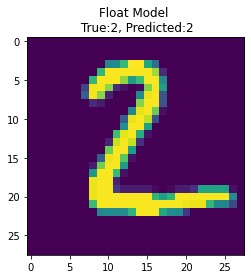

In [ ]:
test_model(tflite_model_file, test_image_index, model_type="Float")

그리고 양자화된 모델을 테스트합니다.

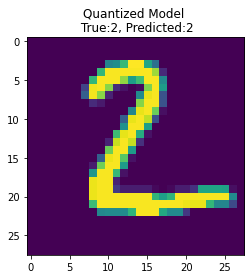

In [ ]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

### 모든 이미지에서 모델 평가하기

이제 이 튜토리얼의 시작 부분에서 로드한 모든 테스트 이미지를 사용하여 두 모델을 모두 실행해보겠습니다.

In [ ]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

부동 모델을 평가합니다.

In [ ]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 97.8700% (Number of test samples=10000)


양자화된 모델을 평가합니다.

In [ ]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 97.8100% (Number of test samples=10000)


이제 부동 모델과 비교하여 정확성에 거의 차이가 없는 정수로 모델을 양자화했습니다.

다른 양자화 전략에 대해 자세히 알아 보려면 [TensorFlow Lite 모델 최적화](https://www.tensorflow.org/lite/performance/model_optimization)에 대해 읽어보세요.